<div class="alert alert-block alert-info">
<b>Notebook Description:</b> Este Notebook tem o objetivo implementar um modelo neural sequencial com 2 camadas escondidas, com funções de ativação ReLu como uma evolução do primeiro modelo implementando buscando a melhoria no desempenho na predição de refin.
</div>

### **SUMÁRIO**
>1. [01 - Pacotes Necessário](#pacotes)
>2. [02 - Carga de Dados](#carga-dados)
>3. [03 - Sobre o Modelo](#info)
>4. [04 - Conjunto de Dados de Treinamento e Teste](#datasets)
>5. [05 - Implamentação do Modelo](#impModelo)
    >>5.1 [05.1 - Função SIGMOID](#sigmoid)<br>
    >>5.2 [05.2 - Função para Inicializar os Parametros e Bias](#inicializar)<br>

***
<font size="6"><a id="pacotes">01 - Pacotes Necessários</a></font>
***

<div class="alert alert-block alert-success">
<b>Descrição: </b> Esta seção tem como objetivo instalar e carregar todos os pacotes necessários para as análises. Estamos utilizando aqui a biblioteca Keras, um "front-end" para utilização do tensorflow, utilizaremos estas bibliotecas para a construção e treinamento do modelo.
</div>

In [1]:
import sys
import types
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dropout, Dense

from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
import h5py
import gc

import tarfile
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json
from keras.callbacks import History 
from contextlib import suppress
import os

Using TensorFlow backend.


ModuleNotFoundError: No module named 'watson_machine_learning_client'

***
<font size="6"><a id="carga-dados">02 - Carga de Dados</a></font>
***

<div class="alert alert-block alert-success">
<b>Descrição: </b> Esta seção tem como objetivo carregar os dados tratados no notebook  ML - 01 - Arquivo Treinamento para treinamento e teste do modelo.
</div>

In [2]:
def DownloadAndLoadFiles(filename: str):
    
    print('*'*50)
    print('*   Fazer o download do Arquivo {}    *'.format(filename))
    print('*'*50)
    
    cosFiles.download_file(Bucket='04work-crm',Key=filename,Filename=filename)
    
    print('*'*50)
    print('* Carregar o Arquivo {} em um DataFrame  *'.format(filename))
    print('*'*50)
    
    dfFile = pd.read_csv(filename)
    
    print('*'*50)
    print('*  Carga do Arquivo {} executado  *'.format(filename))
    print('*'*50)
    
    return dfFile

In [3]:
cos_credentials={
  "apikey": 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', #credenciais removidas por motivo de segurança
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/f819585dc4c43dfca0a953a8fc2635bb:a5bc02d4-816f-4d0b-8830-bd98421cb97f::",
  "iam_apikey_name": 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', #credenciais removidas por motivo de segurança
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/f819585dc4c43dfca0a953a8fc2635bb::serviceid:ServiceId-2e1053db-c54b-46d5-821c-85b692c0ac0e",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/f819585dc4c43dfca0a953a8fc2635bb:a5bc02d4-816f-4d0b-8830-bd98421cb97f::"
}
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

In [4]:
cosFiles = ibm_boto3.client('s3',
                       ibm_api_key_id=cos_credentials['apikey'],
                       ibm_service_instance_id=cos_credentials['resource_instance_id'],
                       ibm_auth_endpoint=auth_endpoint,
                       config=Config(signature_version='oauth'),
                       endpoint_url=service_endpoint)

In [5]:
dfData = DownloadAndLoadFiles('ArquivoTreinamento.csv')

**************************************************
*   Fazer o download do Arquivo ArquivoTreinamento.csv    *
**************************************************
**************************************************
* Carregar o Arquivo ArquivoTreinamento.csv em um DataFrame  *
**************************************************
**************************************************
*  Carga do Arquivo ArquivoTreinamento.csv executado  *
**************************************************


In [6]:
dfData.head()

,TAXA,QUANT_PRESTACAO,VALOR_FINANCIADO,VALOR_PRESTACAO,DURACAO_CONTRATO,y,FLAG_SE_EH_REFIN,STATUS_A,STATUS_C,STATUS_E,CANAL_BPV,CANAL_CORRESPONDENTE,CANAL_INTERNET,CANAL_OUTROS,GRPCONV_A-INSS,GRPCONV_B-SIAPE,GRPCONV_C-EST MT,GRPCONV_D-EST SC,GRPCONV_E-OUTROS
0,0.315140,0.468085,0.009895,0.013569,0.058945,1,0,0,0,1,0,1,0,0,1,0,0,0,0
1,0.538059,1.000000,0.025711,0.031853,0.530507,1,1,0,0,1,0,1,0,0,0,0,0,0,1
2,0.536430,1.000000,0.013512,0.016625,0.482937,1,0,0,0,1,0,1,0,0,0,1,0,0,0
3,0.475328,0.744681,0.014933,0.018747,0.765253,0,1,0,0,1,0,1,0,0,1,0,0,0,0
4,0.443015,0.989362,0.253108,0.270901,0.248190,1,1,0,0,1,0,0,0,1,0,0,0,0,1


In [7]:
bSample = False

In [8]:
if bSample:
    #Gerar Sample do total apenas para manipular o notebook com mais agilidade, para salvar o arquivo final, não será gerado sample.
    dfData = dfData.sample(n=int(dfData.shape[0]*0.05))
    print('Shape do Data Frame com 5% de Amostra: ', dfData.shape)

***
<font size="6"><a id="info">03 - Sobre o Modelo</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b> O modelo abaixo implementa duas comandas escondidas que são ativivadas com a função ReLu (Rectified Liner Units) e a camanda de saída que é ativada pela função Sigmoid. Apenas 4 neuronios por camada escondida foram criados, mas poderemos rever este hyperparametro mais para frente.
</div>

### Função ReLu
É a função de ativação mais comum utilizada em modelos de Deep Learning. Valores menores que 0 (negativos) fazem com que a função retorne 0 e para valores positivos o maior valor pode ser até o valor inputado, ou seja, a equação para ReLu pode ser descrita como:

$$ \mathcal{f}{(x)} = max{(0, x)}$$

<img src="https://raw.githubusercontent.com/BancoOle-Analytics/Images/master/Sequencial_Keras.png" width="1000" height="700">

***
<font size="6"><a id="datasets">04 - Conjunto de Dados de Treinamento e Teste</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b> A seção abaixo tem como objetivo gerar os conjunto de dados de treinamento e teste, considerando as feartures (xTrain e xTest) e label (yTrain e yTest)
</div>

In [9]:
#Guardar em um DataFrame apenas as Saídas (label)
dfTest = dfData['y']
#Remover as saídas (label) do Dataframe original para gerar o teste e o treinamento
arRemore = ['y']
dfTrain = dfData.drop(columns=arRemore)

In [10]:
print('Shape y:',dfTest.shape)
print('Shape X:',dfTrain.shape)

Shape y: (100000,)
Shape X: (100000, 18)


In [11]:
#Utilizar o sklearn para gerar os sets necessários
X_train, X_test, Y_train, Y_test = train_test_split(dfTrain.values, dfTest.values, test_size=0.33)

In [12]:
print('Shape X Train: ',X_train.shape)
print('Shape Y Train: ',Y_train.shape)
print('Shape X Test: ',X_test.shape)
print('Shape Y Test: ',Y_test.shape)

Shape X Train:  (67000, 18)
Shape Y Train:  (67000,)
Shape X Test:  (33000, 18)
Shape Y Test:  (33000,)


In [13]:
del dfData
del dfTrain
del dfTest
gc.collect()

150

***
<font size="6"><a id="modelo">05 - Modelo</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b> A seção abaixo tem como objetivo criar e treinar o modelo neural
</div>

***
<font size="6"><a id="camadas">05.1 - Camadas da Rede Neural</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b> A seção abaixo tem como objetivo criar as camadas da rede neural
</div>

In [14]:
# Atualizar o parametro epochs quando for gerar o modelo final. O valor 5 serve apenas para compilar o modelo rapidamente e testar a gravação dos arquivos h5 e json no COS.
start = time.time()
params = {'first_neuron':8,
            'second_neuron':4,
            #'third_neuron':4,
            'dropout': 0.4,
            'optimizer': Adam,
            'losses': binary_crossentropy,
            'activation':relu,
            'last_activation': 'sigmoid',
            'epochs':50}

model = Sequential()


#First Hidden Layer
model.add(Dense(params['first_neuron'], 
                input_dim=X_train.shape[1], 
                activation=params['activation'],
                kernel_initializer='normal'))
#Dropout
model.add(Dropout(params['dropout']))

#Second  Hidden Layer
model.add(Dense(params['second_neuron'], 
                activation=params['activation'], 
                kernel_initializer='normal'))

#Third  Hidden Layer
#model.add(Dense(params['third_neuron'], 
#                activation=params['activation'], 
#                kernel_initializer='normal'))

#Fourth  Hidden Layer
#model.add(Dense(params['Fifth_neuron'], 
#                activation=params['activation'], 
#                kernel_initializer='normal'))

#Fifth  Hidden Layer
#model.add(Dense(params['fourth_neuron'], 
#                activation=params['activation'], 
#                kernel_initializer='normal'))


#Output Layer
model.add(Dense(1, 
                activation=params['last_activation'], 
                kernel_initializer='normal'))

#Compilando a rede neural
model.compile(loss=params['losses'],
              optimizer=params['optimizer'](),
              metrics=['accuracy'])

#Ajuste do modelo utilzando 150 épocas de treinamento
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_test,Y_test),
                    batch_size=2,
                    epochs=params['epochs'],
                    verbose=2)
end = time.time()
eTime = round((end - start) / 60,0)

print('Elapse Time on Model Fit (In Minutes): ', eTime)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 67000 samples, validate on 33000 samples
Epoch 1/50
 - 232s - loss: 0.2728 - acc: 0.8962 - val_loss: 0.2086 - val_acc: 0.9283
Epoch 2/50
 - 231s - loss: 0.2279 - acc: 0.9247 - val_loss: 0.2059 - val_acc: 0.9302
Epoch 3/50
 - 233s - loss: 0.2246 - acc: 0.9251 - val_loss: 0.2035 - val_acc: 0.9300
Epoch 4/50
 - 234s - loss: 0.2228 - acc: 0.9245 - val_loss: 0.2069 - val_acc: 0.9277
Epoch 5/50
 - 236s - loss: 0.2202 - acc: 0.9253 - val_loss: 0.2024 - val_acc: 0.9309
Epoch 6/50
 - 236s - loss: 0.2184 - acc: 0.9257 - val_loss: 0.2039 - val_acc: 0.9307
Epoch 7/50
 - 230s - loss: 0.2188 - acc: 0.9250 - val_loss: 0.2014 - val_acc: 0.9289
Epoch 8/50
 - 231s - loss: 0.2160 - acc: 0.9257 - val_loss: 0.1957 - val_acc: 0.9318
Epoch 9/50
 - 231s - loss: 0.2161 -

In [15]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


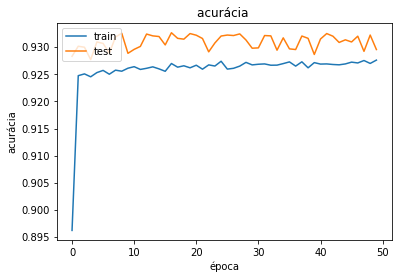

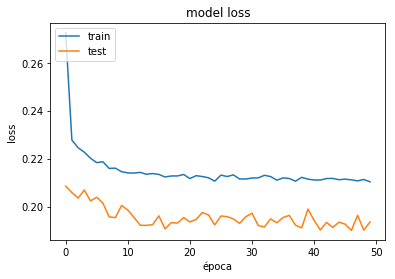

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('acurácia ')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 92.95%


***
<font size="6"><a id="evaluation">05.3 - Avaliar o modelo através da matriz de Confusão</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b>Esta seção tem como objetivo avaliar os resultados obtidos pelo modelo de acordo com o treinamento e o conjunto de testes.
</div>

In [18]:
#Avaliar o modelo
eval_model=model.evaluate(X_train, Y_train)
eval_model

67000/67000 [==============================] - 3s 51us/step


[0.19113279347277398, 0.9305820895522388]

In [19]:
#Classificar utilizando o set de testes
y_pred=model.predict(X_test)
y_pred
#=(y_pred>0.5)

array([[0.9614122 ],
       [0.02952063],
       [0.9344981 ],
       ...,
       [0.85916793],
       [0.92906773],
       [0.9053644 ]], dtype=float32)

***
<font size="6"><a id="evaluation">06 - Persistir o Modelo - Via COS</a></font>
***

<div class="alert alert-block alert-success">
<b>Section Description: </b>Esta seção tem como objetivo persistir o modelo Keras salvando JSON e H5 no COS.
</div>

In [20]:
#1 - Salvar o Arquivo localmente
#1.1 - Definir o nome dos aquivos
filenameH5 = 'RefinPredictionModel-Keras.h5'
filenameJSON = 'RefinPredictionModel-Keras.json'

#1.2 - Remover os arquivos se existirem 
with suppress(OSError):
    os.remove(filenameH5)   
    os.remove(filenameJSON)

#1.3 - Gerar o json do Modelo e grava-lo localmente
model_json = model.to_json()
with open(filenameJSON, "w") as json_file:
    json_file.write(model_json)
#1.4 - Gravar os pesos do modelo localmente
model.save_weights(filenameH5)

#1.5 - Conferir se foram gravados com sucesos
!ls -la

total 12408
drwxr-x--- 2 dsxuser dsxuser     4096 Dec 18 15:54 .
drwx------ 1 dsxuser dsxuser     4096 Dec 18 12:45 ..
-rw-r----- 1 dsxuser dsxuser 12669559 Dec 18 12:45 ArquivoTreinamento.csv
-rw-r----- 1 dsxuser dsxuser    16688 Dec 18 15:54 RefinPredictionModel-Keras.h5
-rw-r----- 1 dsxuser dsxuser     1603 Dec 18 15:54 RefinPredictionModel-Keras.json


In [21]:
#2 - Fazer UPLOAD para Bucket 04work-models de Modelos
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials={
  "apikey": "d9G8MTJTy4EdY0r5jVkCRDMSBFCKfmQaMRW8oOFI0eDD",
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/f819585dc4c43dfca0a953a8fc2635bb:a5bc02d4-816f-4d0b-8830-bd98421cb97f::",
  "iam_apikey_name": "auto-generated-apikey-b4c9dfbc-d2cd-429a-b3c5-4ad08f0735fa",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/f819585dc4c43dfca0a953a8fc2635bb::serviceid:ServiceId-2e1053db-c54b-46d5-821c-85b692c0ac0e",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/f819585dc4c43dfca0a953a8fc2635bb:a5bc02d4-816f-4d0b-8830-bd98421cb97f::"
}
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

cos = ibm_boto3.client('s3',
                       ibm_api_key_id=cos_credentials['apikey'],
                       ibm_service_instance_id=cos_credentials['resource_instance_id'],
                       ibm_auth_endpoint=auth_endpoint,
                       config=Config(signature_version='oauth'),
                       endpoint_url=service_endpoint)

In [22]:
cos.upload_file(Filename=filenameH5,Bucket='04work-crm',Key=filenameH5)
cos.upload_file(Filename=filenameJSON,Bucket='04work-crm',Key=filenameJSON)